In [1]:
import json
import requests
from bs4 import BeautifulSoup as bs
import time

def load_json(file):
    # load json data from "file"
    data = {}
    with open(file) as json_file:
        data = json.load(json_file) #json.load load and open the file
    return data

def dump_json(data, file):
    # dump json "data" to "file"
    with open(file, 'w') as outfile:
        json.dump(data, outfile)

### #Data clean and processing
        

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
table = str.maketrans('', '', string.punctuation)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import label_binarize

five_categories_docs_raw = load_json("five_categories.json")
all_doc_raw=[]
label=[]
for category in five_categories_docs_raw:
    for doc in five_categories_docs_raw[category]:
        doc = json.loads(doc) #json.load convert string data type associate with json to dictionary
        if "text" in doc:# in case there is empty text
            all_doc_raw.append(doc["text"])
            label.append(category)
porter = PorterStemmer()

# Binarize the label output
y = label_binarize(label, classes=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS'])
doc_freq = {}
# split into words
clean_docs=[]
for doc in all_doc_raw:
    # convert to lower case
    doc = doc.lower()
    tokens = word_tokenize(doc)
    # remove punctuation within each word
    tokens = [word.translate(table) for word in tokens]
    # keep only alphas
    tokens=[word for word in tokens if word.isalpha()]
    #filter out stopwords
    tokens = [word for word in tokens if word not in stop_words]
    #stem words
    tokens = [porter.stem(word) for word in tokens]
    for token in set(tokens):
        doc_freq[token]=doc_freq.get(token, 0) + 1
    clean_docs.append(tokens)

# remove low and high frequent tokens
M = len(clean_docs)
for i in range(len(clean_docs)):
    clean_docs[i] = [token for token in clean_docs[i] if doc_freq[token] > M*0.001 
                     and doc_freq[token] < M*0.9]
del doc_freq, all_doc_raw

In [3]:
# save cleaned docs to file
from joblib import dump, load
dump(clean_docs, './clean_docs.joblib')

['./clean_docs.joblib']

### #Convert docs into numerical feature vectors

In [4]:
from collections import Counter
import numpy as np
from scipy.sparse import csr_matrix

#build a vocabulary dictionary which stores the keywords (as dic key) and the 
#document numbers (in a set)
#that contain this key word (as dic value)
df_dict = {}
for i in range(len(clean_docs)):
    tokens = clean_docs[i]
    for word in tokens:
        try:
            df_dict[word].add(i)
        except:
            df_dict[word] = {i}
#calculate TF-IDF
token2id = dict(zip(df_dict.keys(), list(range(len(df_dict)))))
tf_idf = {}
M = len(clean_docs) #Number of documents
N = len(df_dict) #Number of vacabulary
for i in range(M):
    tokens = clean_docs[i]
    counter = Counter(tokens)
    for token in np.unique(tokens):
        tf = counter[token]/len(tokens)
        df = len(df_dict[token])
        idf = np.log(M/(df+1))
        tf_idf[i, token2id[token]] = tf*idf
# Document Vectorization
col, row, val = [], [], []
for k in tf_idf:
    r, c = k
    v = tf_idf[k]
    col.append(c)
    row.append(r)
    val.append(v)
col=np.array(col)
row=np.array(row)
val=np.array(val)
#X is a sparse matrix, the row corresponding to the document number, y 
#corresponding to tf-idf of each keywords
X = csr_matrix((val, (row, col)),shape=(M,N))

In [5]:
print(X.shape)

(26194, 10800)


### #Data splitting

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### count no. of documents per category

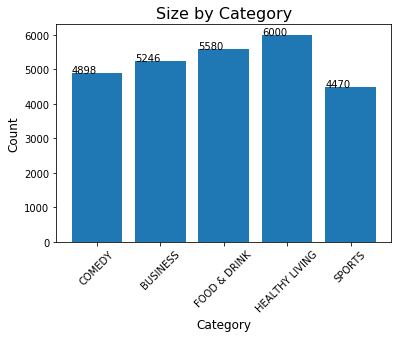

In [9]:
import numpy as np
import matplotlib.pyplot as plt
occurance={} #calculate no. of file in each category
for item in label:
    occurance[item]=occurance.get(item,0)+1
keys=list(occurance.keys())
x = np.arange(len(occurance))#the x locations for the groups
y=list(occurance.values())
bars = plt.bar(x, y)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, yval)
plt.xticks(x, (k for k in keys),rotation=45)
plt.xlabel("Category",fontsize="large")
plt.ylabel("Count",fontsize="large")
plt.title('Size by Category',fontsize=16)
plt.show()

### #Truancated SVD-3k

In [59]:
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#use truncatedSVD to reduce dimension
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
X_train_svd3k = svd.fit_transform(X_train)
print(X_train_svd3k.shape)
print(svd.explained_variance_ratio_.sum())
X_test_svd3k=svd.transform(X_test)

(20955, 3)
0.018758986600517426


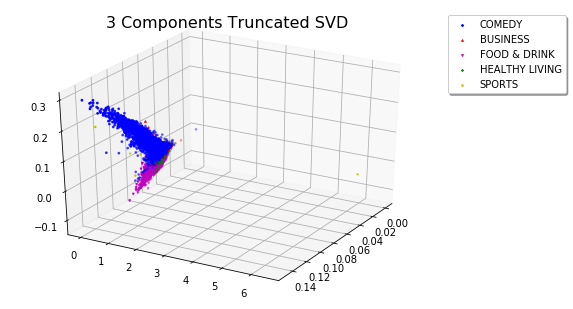

In [60]:
y_train_label=np.array([np.where(r==1)[0][0] for r in y_train])
comedy_index = np.argwhere(y_train_label==0)
business_index=np.argwhere(y_train_label==1)
fooddrink_index=np.argwhere(y_train_label==2)
healthy_index=np.argwhere(y_train_label==3)
sport_index=np.argwhere(y_train_label==4)
comedy=X_train_svd3k[[r[0] for r in comedy_index],:]
business=X_train_svd3k[[r[0] for r in business_index],:]
fooddrink=X_train_svd3k[[r[0] for r in fooddrink_index],:]
health=X_train_svd3k[[r[0] for r in healthy_index],:]
sport=X_train_svd3k[[r[0] for r in sport_index],:]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(comedy[:,0], comedy[:,1], comedy[:,2], 
           color = 'b', marker="o", s=3, label='COMEDY')
ax.scatter(business[:,0],business[:,1],business[:,2],
          color = 'r', marker="^",s=3, label='BUSINESS')
ax.scatter(fooddrink[:,0],fooddrink[:,1],fooddrink[:,2],
          color = 'm', marker="v",s=3, label='FOOD & DRINK')
ax.scatter(health[:,0],health[:,1],health[:,2],
          color = 'g', marker="*",s=3, label='HEALTHY LIVING')
ax.scatter(sport[:,0],sport[:,1],sport[:,2],
           color = 'y', marker="p",s=3, label='SPORTS')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('3 Components Truncated SVD',fontsize=16)
ax.view_init(30, 30)
plt.show()

In [61]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_svd3k, y_train).decision_function(X_test_svd3k)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

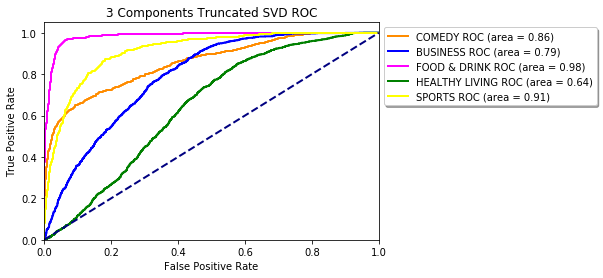

In [62]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('3 Components Truncated SVD ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [14]:
%timeit X_train_svd3k = svd.fit_transform(X_train)

1.1 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### #Truancated SVD-6k

In [63]:
#use truncatedSVD to reduce dimension
svd = TruncatedSVD(n_components=6, n_iter=7, random_state=42)
X_train_svd = svd.fit_transform(X_train)
print(X_train_svd.shape)
print(svd.explained_variance_ratio_.sum())
X_test_svd=svd.transform(X_test)

(20955, 6)
0.03220099238812757


In [64]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_svd, y_train).decision_function(X_test_svd)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

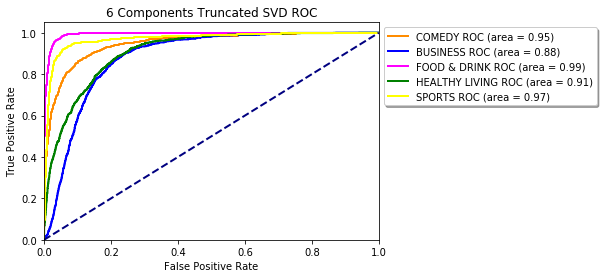

In [65]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('6 Components Truncated SVD ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### # 90% Truncated SVD + LDA-3k

In [66]:
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#use truncated svd to reduce dimension first to solve the singularity issue
svd = TruncatedSVD(n_components=4000, n_iter=7, random_state=42)
X_train_svd = svd.fit_transform(X_train)
print(X_train_svd.shape)
print(svd.explained_variance_ratio_.sum())
X_test_svd=svd.transform(X_test)

(20955, 4000)
0.8941857894111458


In [67]:
#lda dimension reduction
lda = LDA(n_components=3)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, [np.where(r==1)[0][0] for r in y_train])
X_test_lda = lda.transform(X_test_svd)

In [68]:
# Learn to predict each class against the other
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
#classifier = OneVsOneClassifier(LinearDiscriminantAnalysis())
y_score = classifier.fit(X_train_lda, y_train).decision_function(X_test_lda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

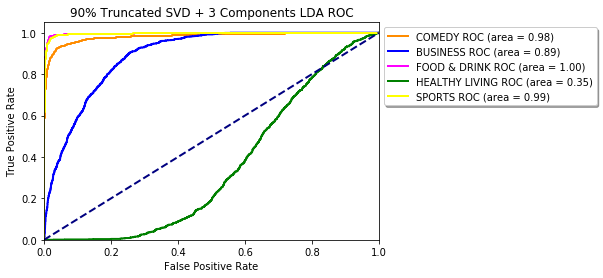

In [69]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('90% Truncated SVD + 3 Components LDA ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [22]:
comedy=X_train_lda[[r[0] for r in comedy_index],:]
business=X_train_lda[[r[0] for r in business_index],:]
fooddrink=X_train_lda[[r[0] for r in fooddrink_index],:]
health=X_train_lda[[r[0] for r in healthy_index],:]
sport=X_train_lda[[r[0] for r in sport_index],:]

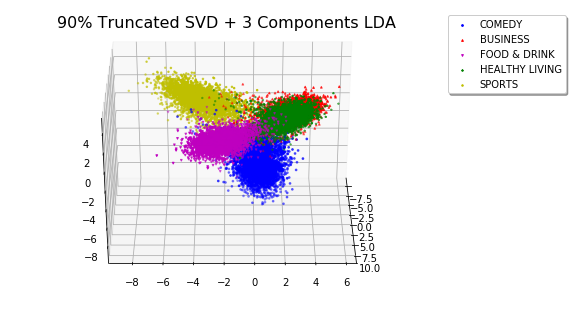

In [24]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(comedy[:,0], comedy[:,1], comedy[:,2], 
           color = 'b', marker="o", s=3, label='COMEDY')
ax.scatter(business[:,0],business[:,1],business[:,2],
          color = 'r', marker="^",s=3, label='BUSINESS')
ax.scatter(fooddrink[:,0],fooddrink[:,1],fooddrink[:,2],
          color = 'm', marker="v",s=3, label='FOOD & DRINK')
ax.scatter(health[:,0],health[:,1],health[:,2],
          color = 'g', marker="*",s=3, label='HEALTHY LIVING')
ax.scatter(sport[:,0],sport[:,1],sport[:,2],
           color = 'y', marker="p",s=3, label='SPORTS')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('90% Truncated SVD + 3 Components LDA',fontsize=16)
ax.view_init(30, 0)
plt.show()

In [143]:
%timeit X_train_svd = svd.fit_transform(X_train)

10min 49s ± 6min 19s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
%timeit X_train_lda = lda.fit_transform(X_train_svd, 
                                        [np.where(r==1)[0][0] for r in y_train])

1min 36s ± 7.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### # 90% Truncated SVD + LDA-4k

In [70]:
#lda dimension reduction
lda = LDA(n_components=4)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, [np.where(r==1)[0][0] for r in y_train])
X_test_lda = lda.transform(X_test_svd)

In [71]:
# Learn to predict each class against the other
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
#classifier = OneVsOneClassifier(LinearDiscriminantAnalysis())
y_score = classifier.fit(X_train_lda, y_train).decision_function(X_test_lda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

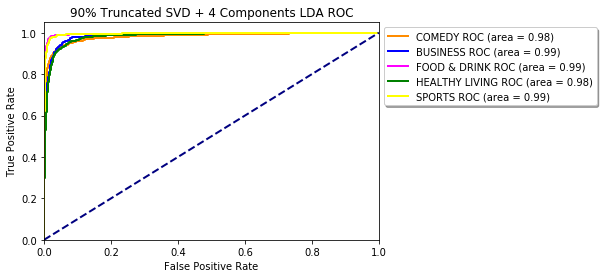

In [72]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('90% Truncated SVD + 4 Components LDA ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### # 70% Truncated SVD + LDA-3k

In [73]:
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#use truncated svd to reduce dimension first to solve the singularity issue
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
X_train_svd = svd.fit_transform(X_train)
print(X_train_svd.shape)
print(svd.explained_variance_ratio_.sum())
X_test_svd=svd.transform(X_test)

(20955, 2000)
0.7262121755785873


In [74]:
#lda dimension reduction
lda = LDA(n_components=3)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, 
                                [np.where(r==1)[0][0] for r in y_train])
X_test_lda = lda.transform(X_test_svd)

In [75]:

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_lda, y_train).decision_function(X_test_lda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

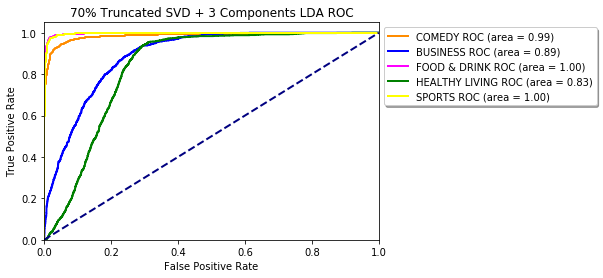

In [76]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('70% Truncated SVD + 3 Components LDA ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [27]:
comedy=X_train_lda[[r[0] for r in comedy_index],:]
business=X_train_lda[[r[0] for r in business_index],:]
fooddrink=X_train_lda[[r[0] for r in fooddrink_index],:]
health=X_train_lda[[r[0] for r in healthy_index],:]
sport=X_train_lda[[r[0] for r in sport_index],:]

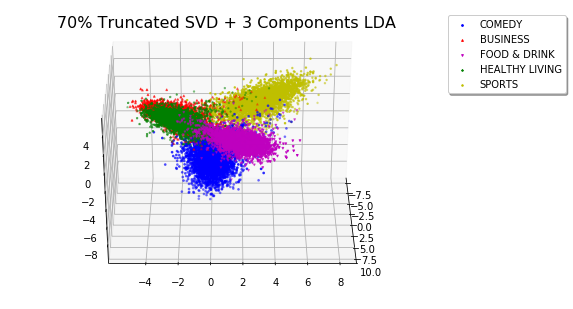

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(comedy[:,0], comedy[:,1], comedy[:,2], 
           color = 'b', marker="o", s=3, label='COMEDY')
ax.scatter(business[:,0],business[:,1],business[:,2],
          color = 'r', marker="^",s=3, label='BUSINESS')
ax.scatter(fooddrink[:,0],fooddrink[:,1],fooddrink[:,2],
          color = 'm', marker="v",s=3, label='FOOD & DRINK')
ax.scatter(health[:,0],health[:,1],health[:,2],
          color = 'g', marker="*",s=3, label='HEALTHY LIVING')
ax.scatter(sport[:,0],sport[:,1],sport[:,2],
           color = 'y', marker="p",s=3, label='SPORTS')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('70% Truncated SVD + 3 Components LDA',fontsize=16)
ax.view_init(30, 0)
plt.show()

In [147]:
%timeit X_train_svd = svd.fit_transform(X_train)

3min 3s ± 8.78 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [148]:
%timeit X_train_lda = lda.fit_transform(X_train_svd, 
                                        [np.where(r==1)[0][0] for r in y_train])

21.1 s ± 602 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### # 70% Truncated SVD + LDA-4k

In [77]:
#lda dimension reduction
lda = LDA(n_components=4)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, 
                                [np.where(r==1)[0][0] for r in y_train])
X_test_lda = lda.transform(X_test_svd)

In [78]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_lda, y_train).decision_function(X_test_lda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

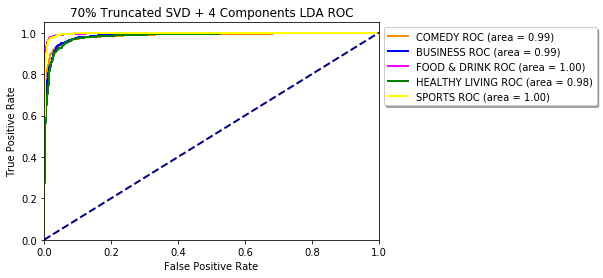

In [79]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('70% Truncated SVD + 4 Components LDA ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### # 60% Truncated SVD + LDA-4k

In [80]:
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#use truncated svd to reduce dimension first to solve the singularity issue
svd = TruncatedSVD(n_components=1300, n_iter=7, random_state=42)
X_train_svd = svd.fit_transform(X_train)
print(X_train_svd.shape)
print(svd.explained_variance_ratio_.sum())
X_test_svd=svd.transform(X_test)

(20955, 1300)
0.6136038937791377


In [81]:
#lda dimension reduction
lda = LDA(n_components=4)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, 
                                [np.where(r==1)[0][0] for r in y_train])
X_test_lda = lda.transform(X_test_svd)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_lda, y_train).decision_function(X_test_lda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

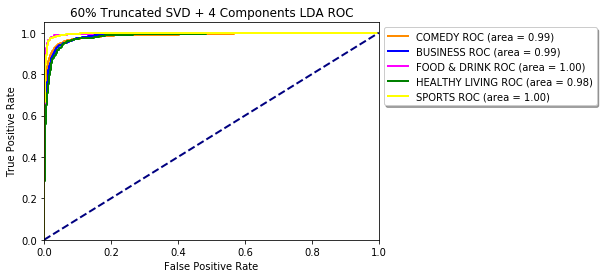

In [82]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('60% Truncated SVD + 4 Components LDA ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

###  # 60% Truncated SVD + LDA-3k

In [83]:
#lda dimension reduction
lda = LDA(n_components=3)
#need to convert y to 1-hot encoding to integer
X_train_lda= lda.fit_transform(X_train_svd, 
                               [np.where(r==1)[0][0] for r in y_train])
X_test_lda = lda.transform(X_test_svd)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_lda, y_train).decision_function(X_test_lda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

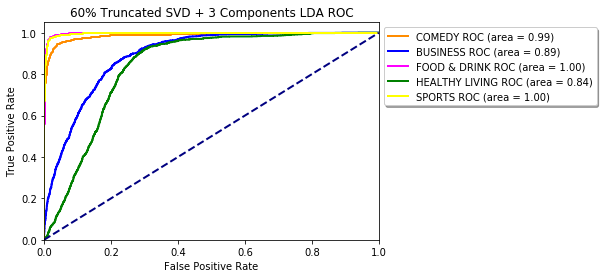

In [84]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('60% Truncated SVD + 3 Components LDA ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [126]:
comedy=X_train_lda[[r[0] for r in comedy_index],:]
business=X_train_lda[[r[0] for r in business_index],:]
fooddrink=X_train_lda[[r[0] for r in fooddrink_index],:]
health=X_train_lda[[r[0] for r in healthy_index],:]
sport=X_train_lda[[r[0] for r in sport_index],:]

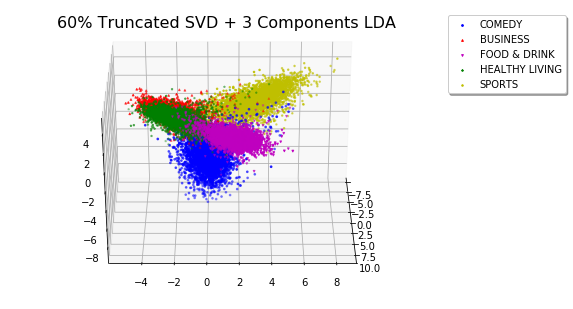

In [127]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(comedy[:,0], comedy[:,1], comedy[:,2], 
           color = 'b', marker="o", s=3, label='COMEDY')
ax.scatter(business[:,0],business[:,1],business[:,2],
          color = 'r', marker="^",s=3, label='BUSINESS')
ax.scatter(fooddrink[:,0],fooddrink[:,1],fooddrink[:,2],
          color = 'm', marker="v",s=3, label='FOOD & DRINK')
ax.scatter(health[:,0],health[:,1],health[:,2],
          color = 'g', marker="*",s=3, label='HEALTHY LIVING')
ax.scatter(sport[:,0],sport[:,1],sport[:,2],
           color = 'y', marker="p",s=3, label='SPORTS')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('60% Truncated SVD + 3 Components LDA',fontsize=16)
ax.view_init(30, 0)
plt.show()

In [151]:
%timeit X_train_svd = svd.fit_transform(X_train)

1min 44s ± 7.59 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit X_train_lda = lda.fit_transform(X_train_svd,
                                        [np.where(r==1)[0][0] for r in y_train])

14.4 s ± 297 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### # 10% Truncated SVD + LDA-3k

In [85]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X_train_svd = svd.fit_transform(X_train)
print(X_train_svd.shape)
print(svd.explained_variance_ratio_.sum())
X_test_svd=svd.transform(X_test)

(20955, 50)
0.12294787249190167


In [86]:
#lda dimension reduction
lda = LDA(n_components=3)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, 
                                [np.where(r==1)[0][0] for r in y_train])
comedy=X_train_lda[[r[0] for r in comedy_index],:]
business=X_train_lda[[r[0] for r in business_index],:]
fooddrink=X_train_lda[[r[0] for r in fooddrink_index],:]
health=X_train_lda[[r[0] for r in healthy_index],:]
sport=X_train_lda[[r[0] for r in sport_index],:]

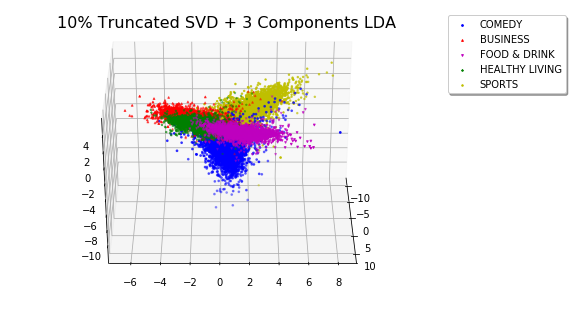

In [87]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(comedy[:,0], comedy[:,1], comedy[:,2], 
           color = 'b', marker="o", s=3, label='COMEDY')
ax.scatter(business[:,0],business[:,1],business[:,2],
          color = 'r', marker="^",s=3, label='BUSINESS')
ax.scatter(fooddrink[:,0],fooddrink[:,1],fooddrink[:,2],
          color = 'm', marker="v",s=3, label='FOOD & DRINK')
ax.scatter(health[:,0],health[:,1],health[:,2],
          color = 'g', marker="*",s=3, label='HEALTHY LIVING')
ax.scatter(sport[:,0],sport[:,1],sport[:,2],
           color = 'y', marker="p",s=3, label='SPORTS')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('10% Truncated SVD + 3 Components LDA',fontsize=16)
ax.view_init(30, 0)
plt.show()

In [88]:
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, 
                                [np.where(r==1)[0][0] for r in y_train])
X_test_lda = lda.transform(X_test_svd)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_lda, y_train).decision_function(X_test_lda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

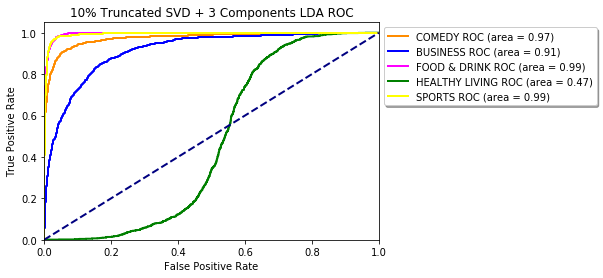

In [89]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10% Truncated SVD + 3 Components LDA ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [159]:
%timeit X_train_svd = svd.fit_transform(X_train)

10.3 s ± 3.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [160]:
%timeit X_train_lda = lda.fit_transform(X_train_svd, 
                                        [np.where(r==1)[0][0] for r in y_train])

507 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
#lda dimension reduction
lda = LDA(n_components=4)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, 
                                [np.where(r==1)[0][0] for r in y_train])
X_test_lda = lda.transform(X_test_svd)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_lda, y_train).decision_function(X_test_lda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

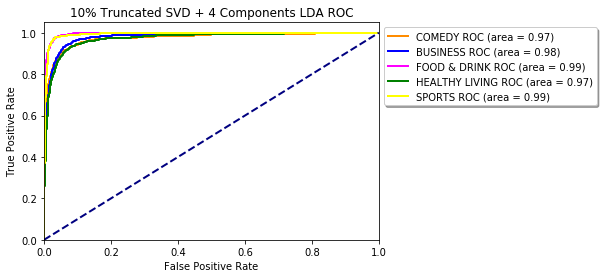

In [91]:
#Plot of a ROC curve for each class
plt.figure()
y_label=['COMEDY', 'BUSINESS','FOOD & DRINK','HEALTHY LIVING','SPORTS']
color=['darkorange','blue','magenta','green','yellow']
for i in list(range(5)):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=2, label=y_label[i]+' ROC (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10% Truncated SVD + 4 Components LDA ROC')
plt.legend(loc='upper left', shadow=True, fontsize='medium', 
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### Try k1 LDA reduction with each pair 

In [92]:
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#use truncated svd to reduce dimension first to solve the singularity issue
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X_train_svd = svd.fit_transform(X_train)
print(X_train_svd.shape)
print(svd.explained_variance_ratio_.sum())
X_test_svd=svd.transform(X_test)

(20955, 50)
0.12294787249190167


###### Business VS Rest

In [93]:
#convert binary labels to 0,1,2,3,4 corresponding to each class
y_train_label=np.array([np.where(r==1)[0][0] for r in y_train])
y_test_label=np.array([np.where(r==1)[0][0] for r in y_test])

#keep buisiness category as 1 and all the remaining categories as 0
y_train_label[np.argwhere(y_train_label==2)]=0
y_train_label[np.argwhere(y_train_label==3)]=0
y_train_label[np.argwhere(y_train_label==4)]=0
y_test_label[np.argwhere(y_test_label==2)]=0
y_test_label[np.argwhere(y_test_label==3)]=0
y_test_label[np.argwhere(y_test_label==4)]=0

In [94]:
#lda dimension reduction
lda = LDA(n_components=1)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, y_train_label)
X_test_lda = lda.transform(X_test_svd)

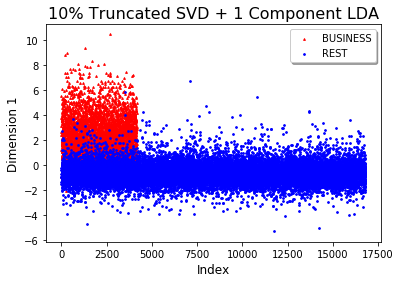

In [95]:
business_index=np.argwhere(y_train_label==1)
rest_index=np.argwhere(y_train_label==0)
business=X_train_lda[business_index]
rest=X_train_lda[rest_index]
plt.scatter(list(range(4160)), business, color = 'r', marker="^",s=3, label='BUSINESS')
plt.scatter(list(range(16795)), rest, color = 'b', marker="o", s=3, label='REST')   
plt.legend(loc='upper right',shadow=True, fontsize='medium')
plt.xlabel('Index',fontsize="large")
plt.ylabel('Dimension 1',fontsize="large")
plt.title('10% Truncated SVD + 1 Component LDA',fontsize=16)
plt.show()

In [96]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_lda, y_train_label).decision_function(X_test_lda)
y_test_roc = label_binarize(y_test_label, classes=[0, 1])#binarize y_test label
fpr, tpr, _ = roc_curve(y_test_roc, y_score)
roc_auc= auc(fpr, tpr)

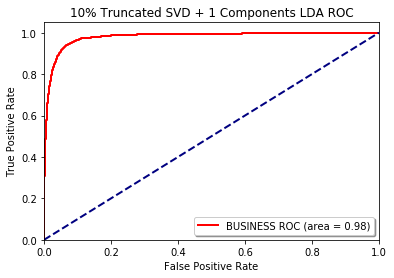

In [97]:
#Plot of a ROC curve for each class
plt.plot(fpr, tpr, color='r',
         lw=2, label='BUSINESS'+' ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10% Truncated SVD + 1 Components LDA ROC')
plt.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

###### Healthy Living VS Rest

In [98]:
#convert binary labels to 0,1,2,3,4 corresponding to each class
y_train_label=np.array([np.where(r==1)[0][0] for r in y_train])
y_test_label=np.array([np.where(r==1)[0][0] for r in y_test])

#keep healthy living category as 1 and all the remaining categories as 0
y_train_label[np.argwhere(y_train_label==1)]=0
y_train_label[np.argwhere(y_train_label==2)]=0
y_train_label[np.argwhere(y_train_label==3)]=1
y_train_label[np.argwhere(y_train_label==4)]=0
y_test_label[np.argwhere(y_test_label==1)]=0
y_test_label[np.argwhere(y_test_label==2)]=0
y_test_label[np.argwhere(y_test_label==3)]=1
y_test_label[np.argwhere(y_test_label==4)]=0

In [99]:
#lda dimension reduction
lda = LDA(n_components=1)
#need to convert y to 1-hot encoding to integer
X_train_lda = lda.fit_transform(X_train_svd, y_train_label)
X_test_lda = lda.transform(X_test_svd)

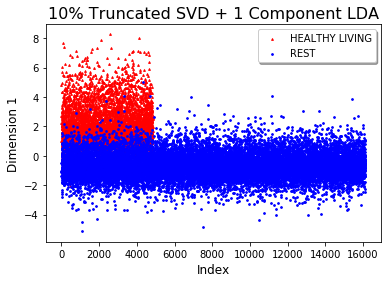

In [100]:
healthy_index=np.argwhere(y_train_label==1)
rest_index=np.argwhere(y_train_label==0)
healthy=X_train_lda[healthy_index]
rest=X_train_lda[rest_index]
plt.scatter(list(range(4838)), healthy, color = 'r', marker="^",s=3, label='HEALTHY LIVING')
plt.scatter(list(range(16117)), rest, color = 'b', marker="o", s=3, label='REST')   
plt.legend(loc='upper right', shadow=True, fontsize='medium')
plt.xlabel('Index',fontsize="large")
plt.ylabel('Dimension 1',fontsize="large")
plt.title('10% Truncated SVD + 1 Component LDA',fontsize=16)
plt.show()

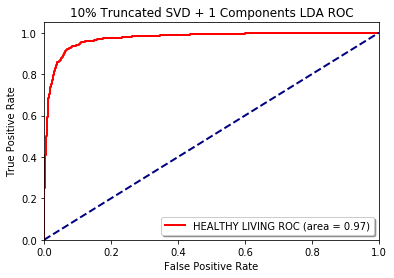

In [101]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_lda, y_train_label).decision_function(X_test_lda)
y_test_roc = label_binarize(y_test_label, classes=[0, 1])#binarize y_test label
fpr, tpr, _ = roc_curve(y_test_roc, y_score)
roc_auc= auc(fpr, tpr)
#Plot of a ROC curve for each class
plt.plot(fpr, tpr, color='r',
         lw=2, label='HEALTHY LIVING'+' ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10% Truncated SVD + 1 Components LDA ROC')
plt.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

### Efficiency comparison

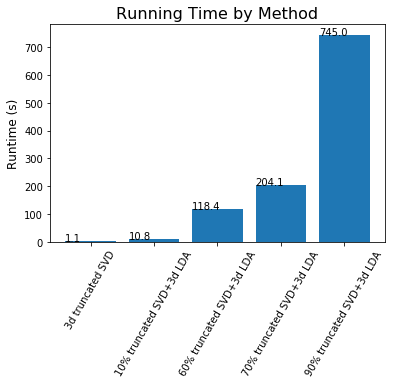

In [176]:
import numpy as np
import matplotlib.pyplot as plt
method=["3d truncated SVD","10% truncated SVD+3d LDA",
        "60% truncated SVD+3d LDA", "70% truncated SVD+3d LDA",
        "90% truncated SVD+3d LDA"]
runtime=[1.1, 10.8, 118.4, 204.1,745.0]
x = np.arange(len(method))#the x locations for the groups
bars = plt.bar(x, runtime)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, yval)
plt.xticks(x, (k for k in method),rotation=60)
plt.ylabel("Runtime (s)",fontsize="large")
plt.title('Running Time by Method',fontsize=16)
plt.show()